# Exercise 1

Team members: Agata Kaczmarek (uni-id), Mateusz Stączek (uni-id)

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from scipy.special import erfinv
from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
from scipy.stats import multivariate_normal
import warnings
warnings.filterwarnings("ignore")

#additional for task 2
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture as GMM
from sklearn.neighbors import KernelDensity
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from collections import Counter

## 1. Two-dimensional data

### Create training and test datasets.

At the beginning two datasets are created - train and test. They are 2-dimensional datasets, created with the help of the function `sklearn.datasets.make_moons()`. The function allows to set various sizes for both datasets.

<div style="color: green; font-weight: bold">Our solution did not use noise when creating the moons dataset. This is still correct but greatly influences the range of MMD errors and best hyperparameters for each model. Additionally, our solution used a train set size of only 100 points but in our case the size of the dataset above 100 would not matter much.</div>

In [2]:
def create_dataset(train_size=100, if_generate_test=True, test_size=100):
    """
    Funtion to create datasets from sklearn.datasets.make_moons().

    Args:
        train_size (int): size of training set that will be created.
        if_generate_test (bool): if test set should be generated.
        test_size (int): size of test set that will be created.
    """
    train_set,train_labels =datasets.make_moons(n_samples=train_size,random_state=123)
    if if_generate_test:
        test_set,test_labels =datasets.make_moons(n_samples=test_size, random_state=123)
    else:
        test_set, test_labels=np.array([]), np.array([])
    
    return train_set, train_labels, test_set, test_labels

The generated datasets can be plotted and look like below. Two classes, each in moon shape, can be clearly seen for both datasets.

In [3]:
train_set, train_labels, test_set, test_labels=create_dataset()

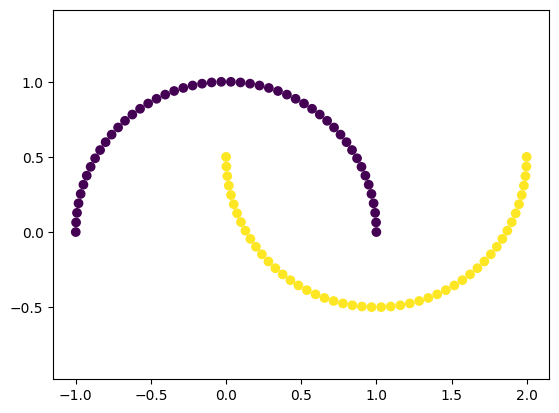

In [4]:
plt.scatter(train_set[:,0], train_set[:,1], c=train_labels)
plt.axis('equal')
plt.show()

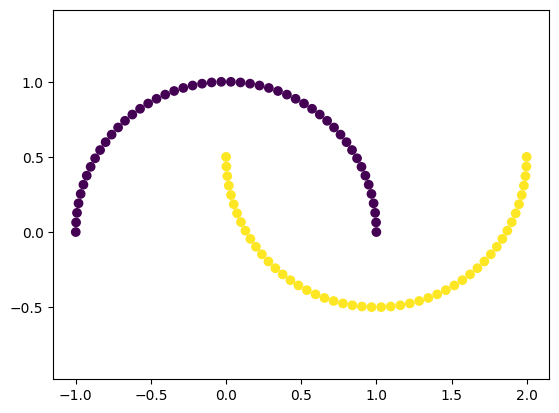

In [5]:
plt.scatter(test_set[:,0], test_set[:,1], c=test_labels)
plt.axis('equal')
plt.show()

### Implementation of a two-dimensional histogram.

Below there is an implementation of a two-dimensional histogram. The implementation contains two functions `two_d_histogram()` and `generate_data_histogram()`.

<div style="color: green; font-weight: bold">Our code differs - it is not nicely packed into a class that inherits and extends sklearn classes. Additionally, we return a matrix not scaled to sum to 1 which makes it a matrix of counts. It is a difference but it is still correct.</div>

<div style="color: green; font-weight: bold">Our code is slow - caused by using for loops instead of np.ditize(..) function during computing the histogram. Also, during sampling, our code samples one point at a time. It is still correct.</div>

In [6]:
def two_d_histogram(train_set, bin_size=1):
    """
    Function that is an implementation of two-dimensional histogram.

    Args:
        train_set (np.array): set that is used to train the histogram.
        bin_size (int): size of bin.
    """
    num_of_points=len(train_set[:,0])
    X_max=max(train_set[:,0])
    X_min=min(train_set[:,0])
    y_max = max(train_set[:,1])
    y_min = min(train_set[:,1])
    L_x=int(np.ceil((X_max-X_min)/bin_size)) 
    L_y=int(np.ceil((y_max-y_min)/bin_size)) 
    list_x_and_L=[X_max, X_min, y_max, y_min, L_x, L_y, bin_size]

    count_matrix = [[0 for x in range(L_x)] for y in range(L_y)] 
    count2=0
    list_of_occurencies=[0 for x in range(num_of_points)] 
    for i in range(L_x):
        for j in range(L_y):
            count=0
            section_x_beginning=X_min+i*bin_size
            section_y_beginning=y_min+j*bin_size
            length_x=bin_size
            length_y=bin_size

            for k in range(num_of_points):
                count+=1
                if train_set[k,0]>=section_x_beginning and train_set[k,0]<=(section_x_beginning+length_x) and train_set[k,1]>=section_y_beginning and train_set[k,1]<=(section_y_beginning+length_y):
                    if list_of_occurencies[k]==0:
                        count2+=1
                        count_matrix[j][i]+=1
                        list_of_occurencies[k]+=1

    model_parameters = {
        "count_matrix": np.array(count_matrix),
        "list_x_and_L": list_x_and_L
    }
    return model_parameters
    
def generate_data_histogram(model_parameters, number_of_generated=100):
    """
    Function that generates data based on the histogram.

    Args:
        model_parameters (dict): dict with two elements: 
            `count_matrix` - matrix with histogram 
            `list_x_and_L` - list with all information about the histogram.
        number_of_generated (int): number of points that will be generated.
    """
    matrix_of_counts = model_parameters["count_matrix"]
    list_x_and_L = model_parameters["list_x_and_L"]
    X_max, X_min, y_max, y_min, L_x, L_y, bin_size=list_x_and_L
    cumsum_matrix=np.cumsum(matrix_of_counts)
    max_number=max(cumsum_matrix)

    list_of_generated=[]
    for i in range(number_of_generated):
        number=np.random.randint(1, high=max_number+1)
        for j in range(len(cumsum_matrix)):
            if number<=cumsum_matrix[j]:
                break
        num_y=np.floor(j/L_x)
        num_x=j-L_x*num_y
        random_x=np.random.uniform(X_min+num_x*bin_size, X_min+(num_x+1)*bin_size)
        random_y=np.random.uniform(y_min+(num_y)*bin_size, y_min+(num_y+1)*bin_size)
        list_of_generated.append([random_x, random_y])
    list_of_generated=np.array(list_of_generated)
    return list_of_generated

### Implementation of a single Gaussian.

Below there is an implementation of a single Gaussian. The implementation contains two functions that generate samples `our_sample_from_standard_normal()` and `our_sample_from_multivariate_normal()`. There are also two functions for training and generating the results `train_single_gaussian()` and  `generate_data_single_gaussian()`.

<div style="color: green; font-weight: bold">Difference: we first sample from uniform and then transform to standard normal while the correct solution starts by sampling from standard normal. Other than that, there are no differences.</div>

In [7]:
def our_sample_from_standard_normal(size=(1,)):
    """
    Function that generates data from standard normal distribution.

    Args:
        size (tuple): number of generated points.
    """
    generated_uniform = np.random.uniform(size=size)
    # change generated uniform to standard normal using erfinv function as in the lecture
    generated_standard_normal = np.sqrt(2) * erfinv(2 * generated_uniform - 1)
    return generated_standard_normal


def our_sample_from_multivariate_normal(mean, cov, size=1):
    """
    Function that generates data from multivariate normal distribution.

    Args:
        mean (np.array): mean of distribution.
        cov (np.array): covariance matrix of distribution.
        size (int): number of generated points.
    """
    eigenvalues, eigenvectors=np.linalg.eig(cov)

    generated_standard_normal = our_sample_from_standard_normal(size=(size, len(mean)))
    # change generated standard normal to multivariate normal distribution as in the lecture
    generated_multivariate_normal = generated_standard_normal @ np.diag(np.sqrt(eigenvalues)) @ eigenvectors.T + mean
    return generated_multivariate_normal

In [8]:
def train_single_gaussian(train_set):
    """
    Function that finds parameters for a single gaussian distribution.

    Args:
        train_set (np.array): array of train set.
    """
    mean = np.mean(train_set, axis=0)
    cov = np.cov(train_set.T)
    model_parameters = {"mean":mean, "cov":cov}
    return model_parameters

def generate_data_single_gaussian(model_parameters, number_of_generated=100):
    """
    Function that generates data from single gaussian distribution.

    Args:
        model_parameters (dict): dictionary with mean and cov.
        number_of_generated (int): number of points to generate.
    """
    mean = model_parameters["mean"]
    cov = model_parameters["cov"]
    
    generated_data = our_sample_from_multivariate_normal(mean, cov, size=number_of_generated)

    return generated_data

### Implementation of a Gaussian mixture model (GMM).

Below there is an implementation of a GMM. The implementation contains main functions `multivariate_normal_distribution()`, training one `train_gmm` and one for generating the data `generate_data_gmm`.

<div style="color: green; font-weight: bold">Difference: 
- for initializing means, we use KMeans instead of KMeans plus plus. 
- we did not use regularization term which caused errors when inverting the covariance matrix.
- we initialized covariances with identity matrices and they used variances of data but it's still correct.
- our E-step is slower - uses 2 for loops instead of just 1 as in the solution.
- our M-step does not scale new weight to have a sum of 1, but means and covariances are updated correctly.
Generating new data is correct. </div>

In [9]:
def multivariate_normal_distribution(x, mean, covariance):
    """
    Function that calculates multivariate normal distribution.
    
    Args:
        x (np.array): sample of data.
        mean (np.array): mean of distribution.
        covariance (np.array): covariance matrix of distribution.
    """
    cov_inv = np.linalg.inv(covariance)
    cov_det = np.linalg.det(covariance)
    d = len(x)
    num = np.exp(-1 * np.dot(np.dot((x - mean).T, cov_inv), (x - mean)) / 2)
    den = (2 * np.pi) ** (d / 2) * np.sqrt(cov_det)
    return num / den

def train_gmm(train_set, components=4, n_iterations = 100):
    """
    Function that finds parameters for a gaussian mixture model with N components.

    Args:
        train_set (np.array): array of train set.
        components (int): number of components.
        n_iterations (int): number of iterations.
    """
    n_samples, n_features = train_set.shape

    weights = np.ones(components) / components
    means = KMeans(n_clusters=components, random_state=0, n_init="auto").fit(train_set).cluster_centers_
    covariances = np.array([np.eye(n_features) for _ in range(components)])

    def estimate_importances(X, weights, means, covariances):
        """
        Function for E-step of the EM algorithm.

        Args:
            X (np.array): data set.
            weights (np.array): weights for the EM algorithm.
            means (np.array): means of distribution.
            covariances (np.array): covariance matrixes of distribution.

        """
        importances = np.zeros((len(X), len(weights)))

        for i in range(len(X)):
            for j in range(len(weights)):
                importances[i, j] = weights[j] * multivariate_normal_distribution(X[i], means[j], covariances[j])

            importances[i] /= np.sum(importances[i])

        return importances

    def update_parameters(X, importances):
        """
        Function for M-step of the EM algorithm

        Args:
            X (np.array): data set.
            importances (np.array): importances for the EM algorithm.
        """
        updated_means = np.dot(importances.T, X) / np.sum(importances, axis=0)[:, np.newaxis]

        updated_covariances = np.zeros((components, n_features, n_features))
        for j in range(components):
            diff = X - updated_means[j]
            updated_covariances[j] = np.dot(importances[:, j] * diff.T, diff) / np.sum(importances[:, j])

        updated_weights = np.sum(importances, axis=0) / len(X)

        return updated_weights, updated_means, updated_covariances

    for _ in range(n_iterations):
        importances = estimate_importances(train_set, weights, means, covariances)
        weights, means, covariances = update_parameters(train_set, importances)

    model_parameters = {"weights":weights, "means":means, "covariances":covariances}
    return model_parameters


def generate_data_gmm(model_parameters, number_of_generated=100):
    """
    Function that generates data from gaussian mixture model.

    Args:
        model_parameters (dict): dictionary with parameters of gaussian mixture model.
        number_of_generated (int): number of generated points.
    """
    weights = model_parameters["weights"]
    means = model_parameters["means"]
    covariances = model_parameters["covariances"]

    generated_data = np.zeros((number_of_generated, 2))
    for i in range(number_of_generated):
        k = np.random.choice(len(weights), 1, p=weights)[0]
        generated_data[i] = our_sample_from_multivariate_normal(means[k], covariances[k])

    return generated_data

### Implementation of a kernel density estimator (KDE) with squared exponential kernel.

Below there is an implementation of a KDE. The implementation contains three functions `squared_exponential_kernel()`, training one `train_kde`, one for generating the data `generate_data_kde`.

<div style="color: green; font-weight: bold">Differences:
- we used (in predictions, a bit later, but kernel is implemented here) the correct kernel - squared exponential kernel. The correct solution uses kernel different than in the task description.
Other than that, there are no differences and the code is correct.</div>

In [10]:
def squared_exponential_kernel(x, y, bandwidth):
    """
    Function that calculates squared exponential kernel.

    Args:
        x (np.array): first point.
        y (np.array): second point.
        bandwidth (float): bandwidth of kernel.
    """
    return np.exp(-1 * np.linalg.norm(x - y, axis=2) ** 2 / (2 * bandwidth) )

def train_kde(train_set, bandwidth=1.0):
    """
    Function that returns train set and bandwidth. To match other algorithms.

    Args:
        train_set (np.array): train data set.
        bandwidth (float): bandwidth of kernel.
    """
    model_parameters = {"train_set": train_set, "bandwidth": bandwidth}
    return model_parameters

def generate_data_kde(model_parameters, number_of_generated=100):
    """
    Function that generates data from kernel density estimation.

    Args:
        model_parameters (dict): dictionary with train set and bandwidth.
        number_of_generated (int): number of points to generate.
    """
    train_set = model_parameters["train_set"]
    bandwidth = model_parameters["bandwidth"]
    n_train = train_set.shape[0]
    generated_data = np.zeros((number_of_generated, train_set.shape[1]))

    for i in range(number_of_generated):
        k = np.random.choice(n_train, 1, p=np.ones(n_train) / n_train)[0]
        X_k = train_set[k]
        generated_data[i] = X_k + our_sample_from_multivariate_normal(np.zeros(train_set.shape[1]), np.eye(train_set.shape[1]) * bandwidth)

    return generated_data

### Implementation of maximum mean discrepancy.

With two different kernels - squared exponential and inverse multi-quadratic.

<div style="color: green; font-weight: bold">Differences:
- Our inverse multiquadratic kernel is correct (matches the definition from the lecture). The proposed correct solution differs - their denominator is additionally under a square root.
- our implemented MMD did not drop the redundant portion of the formula which is independent of generated X and measures the differences between every pair of points from the training set which is constant. This did not affect the correctness but added unnecessary coputations.
- our implemented MMD has different denominator in the first part than the proposed correct solution. We put there 'M*(M-1)', same as in the lecture, whereas the proposed solution put there 'M + (M-1)' which is clearly not correct as the sum has 'M * (M-1)' non-zero elements.
- sums in our MMD also add value of the kernel function for every point with itself. This is zero and was left as so on purpose for simplicity.
- Possibly due to the nature of our dataset (without noise) we used a very small bandwidth of just 0.05 compared to the proposed solution using bandwith 1.
</div>

In [11]:
def mmd_kernel_squared_exponential(x,y,h):
    """
    Function that calculates squared exponential kernel.

    Args:
        x (np.array): point.
        y (np.array): point.
        h (float): bandwidth of kernel.
    """
    return np.exp(-1 * np.linalg.norm(x - y) ** 2 / (2 * h) )

def mmd_kernel_inverse_multiquadratic(x,y,h):
    """
    Function that calculates inverse multi-quadratic kernel.

    Args:
        x (np.array): point.
        y (np.array): point.
        h (float): bandwidth of kernel.
    """
    return h / (np.linalg.norm(x - y) ** 2 + h)

def metric_mmd_square(dataset_1, dataset_2, bandwidth, kernel_function):
    """
    Function that calculates squared MMD metric.
    
    Args:
        dataset_1 (np.array): array of points.
        dataset_2 (np.array): array of points.
        bandwidth (float): bandwidth of kernel.
        kernel_function (function): kernel function.
    """
    M = len(dataset_1)
    part_1 = 0
    for i in range(M):
        for j in range(M):
            part_1 += kernel_function(dataset_1[i], dataset_1[j], bandwidth)
    part_1 /= M * (M - 1)

    N = len(dataset_2)
    part_2 = 0
    for i in range(N):
        for j in range(N):
            part_2 += kernel_function(dataset_2[i], dataset_2[j], bandwidth)
    part_2 /= N * (N - 1)

    part_3 = 0
    for i in range(M):
        for j in range(N):
            part_3 += kernel_function(dataset_1[i], dataset_2[j], bandwidth)
    part_3 *= 2 / (M * N)

    mmd_square = part_1 + part_2 - part_3

    return mmd_square

def metric_mmd_wrapper_squared_exponential(dataset):
    """
    Wrapper function that calculates squared MMD metric for given dataset.
    Sets bandwidth to 0.05 and uses squared exponential kernel.
    Uses original test dataset.
    
    Args:
        dataset (np.array): array of points.
    """
    bandwidth = 0.05
    kernel_function = mmd_kernel_squared_exponential
    return metric_mmd_square(test_set, dataset, bandwidth, kernel_function)

def metric_mmd_wrapper_inverse_multiquadratic(dataset):
    """
    Wrapper function that calculates squared MMD metric for given dataset.
    Sets bandwidth to 0.05 and uses inverse multi-quadratic kernel.
    Uses original test dataset.
    
    Args:
        dataset (np.array): array of points.
    """
    bandwidth = 0.05
    kernel_function = mmd_kernel_inverse_multiquadratic
    return metric_mmd_square(test_set, dataset, bandwidth, kernel_function)

### Training of models

All previously implemented models will now be trained below. For each of the models, a new dataset is created, which has the name `new_data_{name of the method}`. In this example, the number of generated points is 100.

<div style="color: green; font-weight: bold">This part is correct</div>

In [12]:
NUMBER_OF_GENERATED_POINTS = 100

In [13]:
model_parameters_two_d_histogram = two_d_histogram(train_set, bin_size=0.1)
new_data_two_d_histogram = generate_data_histogram(model_parameters_two_d_histogram, number_of_generated=NUMBER_OF_GENERATED_POINTS)

In [14]:
model_parameters_single_gaussian = train_single_gaussian(train_set)
new_data_single_gaussian = generate_data_single_gaussian(model_parameters_single_gaussian, number_of_generated=NUMBER_OF_GENERATED_POINTS)

In [15]:
model_parameters_gmm = train_gmm(train_set, components=8, n_iterations = 100)
new_data_gmm = generate_data_gmm(model_parameters_gmm, number_of_generated=NUMBER_OF_GENERATED_POINTS)

In [16]:
model_parameters_kde = train_kde(train_set, bandwidth=0.001)
new_data_kde = generate_data_kde(model_parameters_kde, number_of_generated=NUMBER_OF_GENERATED_POINTS)

### Evaluation of the models

Below we present the values of the metric MMD for each model. There are two types of the metric MMD presented - with squared exponential kernel and with inverse multi-quadratic kernel. The values of the metric are calculated between the test dataset and generated data.

<div style="color: green; font-weight: bold">MMD values are much smaller than from the proposed solution. We believed that this is caused by not adding any noise in our training set. Nonetheless, our results are identical in conclusions as the correct solution - in both cases single gaussian model has much higher score than other models.
An important thing is we measured MMD on test set and not train set as the correct solution.</div>

In [17]:
print('MMD squared with squared exponential kernel:')
print(f'for two-dimensional histogram: {metric_mmd_wrapper_squared_exponential(new_data_two_d_histogram):.6f}')
print(f'for single gaussian: {metric_mmd_wrapper_squared_exponential(new_data_single_gaussian):.6f}')
print(f'for GMM: {metric_mmd_wrapper_squared_exponential(new_data_gmm):.6f}')
print(f'for KDE: {metric_mmd_wrapper_squared_exponential(new_data_kde):.6f}')

MMD squared with squared exponential kernel:
for two-dimensional histogram: 0.010362
for single gaussian: 0.047554
for GMM: 0.015557
for KDE: 0.008852


In [18]:
print('MMD squared with inverse multi-quadratic kernel:')
print(f'for two-dimensional histogram: {metric_mmd_wrapper_inverse_multiquadratic(new_data_two_d_histogram):.6f}')
print(f'for single gaussian: {metric_mmd_wrapper_inverse_multiquadratic(new_data_single_gaussian):.6f}')
print(f'for GMM: {metric_mmd_wrapper_inverse_multiquadratic(new_data_gmm):.6f}')
print(f'for KDE: {metric_mmd_wrapper_inverse_multiquadratic(new_data_kde):.6f}')

MMD squared with inverse multi-quadratic kernel:
for two-dimensional histogram: 0.011436
for single gaussian: 0.041470
for GMM: 0.014929
for KDE: 0.009117


### Visualization of the accuracies

Below we created three functions, which aim to plot accuracies for models - one for histogram (depending on the bin size), GMM (on the number of components) and KDE (kernel bandwidth). All of them also depend on the training set size.

<div style="color: green; font-weight: bold">We did plots in a different manner and believe that they are more readable. We do like, however, that the correct solution put the plots side-by-side for better readability. In terms of included results, we tested fewer different test sizes but for each we evaluated the whole set of hyperparameters. Therefore, we performed more experiments. In general, our code is the same.</div>

In [21]:
def plot_accuracy_histogram(bin_sizes, train_sizes, fig_size=(8,4)):
    """
    Function to plot the accuracy of the histogram.

    Args:
        bin_sizes (float): size of the bin for the histogram.
        train_sizes (list): list of train sizes to be checked for the accuracy.
        fig_size (tuple): size of the resulting plot.
    """
    for train_size in train_sizes:
        train_set, train_labels, test_set, test_labels=create_dataset(if_generate_test=False, train_size=train_size)
        df = pd.DataFrame(columns=['bin_size', 'mmd_squared', 'kernel'])
        for bin_size in bin_sizes:
            model_parameters_two_d_histogram = two_d_histogram(train_set, bin_size=bin_size)
            generated_data = generate_data_histogram(model_parameters_two_d_histogram, number_of_generated=1000)
            df = pd.concat([df, 
                            pd.DataFrame({
                                'bin_size': [bin_size, bin_size],
                                'mmd_squared': [
                                    metric_mmd_wrapper_squared_exponential(generated_data),
                                    metric_mmd_wrapper_inverse_multiquadratic(generated_data)],
                                'kernel': ['squared exponential', 'inverse multi-quadratic']
                            })])
            
        fig, ax = plt.subplots(figsize=fig_size)
        sns.barplot(x='bin_size', y='mmd_squared', hue='kernel', data=df, ax=ax)
        plt.title(f'MMD squared for histogram for train size = {train_size}')
        ax.set_xlabel('Bin size')
        ax.set_ylabel('MMD squared')
        plt.show()

def plot_accuracy_gmm(number_of_components, train_sizes, fig_size=(8,4)):
    """
    Function to plot the accuracy of the GMM.

    Args:
        number_of_components (int): number of components used for the GMM algorithm.
        train_sizes (list): list of train sizes to be checked for the accuracy.
        fig_size (tuple): size of the resulting plot.
    """
    for train_size in train_sizes:
        train_set, train_labels, test_set, test_labels=create_dataset(if_generate_test=False, train_size=train_size)
        df = pd.DataFrame(columns=["components", "mmd_squared", "kernel"])
        for i in number_of_components:
            try:
                model_parameters_gmm = train_gmm(train_set, components=i, n_iterations = 100)
                new_data_gmm = generate_data_gmm(model_parameters_gmm, number_of_generated=1000)
            except:
                continue
            df = pd.concat([df, 
                            pd.DataFrame({
                                "components": [i, i],
                                "mmd_squared": [
                                    metric_mmd_wrapper_squared_exponential(new_data_gmm),
                                    metric_mmd_wrapper_inverse_multiquadratic(new_data_gmm)], 
                                "kernel": ["squared exponential", "inverse multi-quadratic"]
                            })])

        fig, ax = plt.subplots(figsize=fig_size)
        sns.barplot(x="components", y="mmd_squared", hue="kernel", data=df, ax=ax)
        plt.title(f"MMD squared for GMM for train size = {train_size}")
        ax.set_ylabel("MMD squared")
        ax.set_xlabel("Number of components")
        plt.show()

def plot_accuracy_kde(kernel_bandwidths, train_sizes, fig_size=(8,4)):
    """
    Function to plot the accuracy of the KDE.

    Args:
        kernel_bandwidths (float): bandwidths of the kernel used for KDE model.
        train_sizes (list): list of train sizes to be checked for the accuracy.
        fig_size (tuple): size of the resulting plot.
    """
    for train_size in train_sizes:
        train_set, train_labels, test_set, test_labels=create_dataset(if_generate_test=False, train_size=train_size)
        df = pd.DataFrame(columns=["bandwidth", "mmd_squared", "kernel"])
        for bandwidth in kernel_bandwidths:
            model_parameters_kde = train_kde(train_set, bandwidth=bandwidth)
            new_data_kde = generate_data_kde(model_parameters_kde, number_of_generated=1000)
            df = pd.concat([df, 
                            pd.DataFrame({
                                "bandwidth": [bandwidth, bandwidth],
                                "mmd_squared": [
                                    metric_mmd_wrapper_squared_exponential(new_data_kde),
                                    metric_mmd_wrapper_inverse_multiquadratic(new_data_kde)], 
                                "kernel": ["squared exponential", "inverse multi-quadratic"]
                            })])

        fig, ax = plt.subplots(figsize=fig_size)
        sns.barplot(x="bandwidth", y="mmd_squared", hue="kernel", data=df, ax=ax)
        plt.title(f"MMD squared for KDE for train size = {train_size}")
        ax.set_ylabel("MMD squared")
        ax.set_xlabel("Bandwidth hyperparameter")
        plt.show()

<div style="color: green; font-weight: bold">correct, similar results for bigger training size. However, our hyperparameter is the bin size and theirs is number of bins</div>

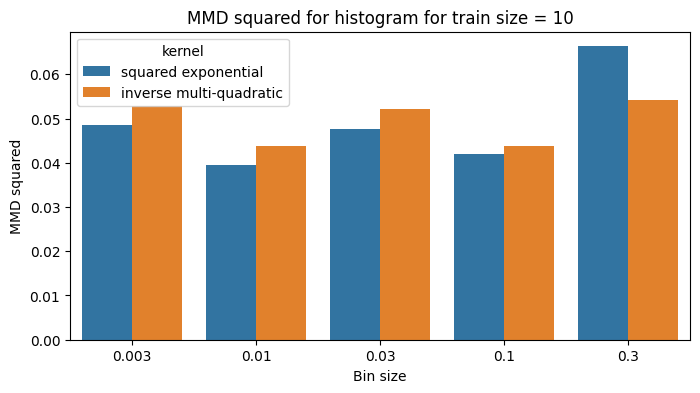

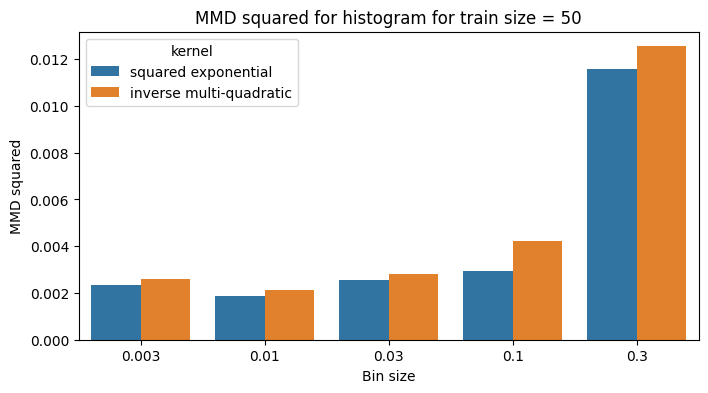

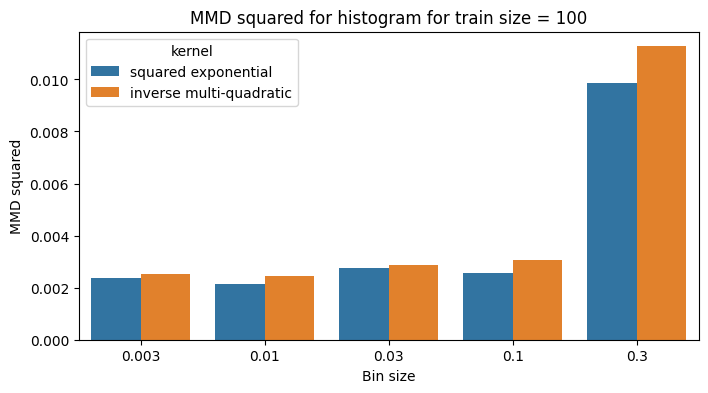

In [22]:
train_sizes=[10,50,100]
plot_accuracy_histogram([0.003, 0.01, 0.03, 0.1, 0.3], train_sizes=train_sizes)

For all cases in histogram values of MMD for both kernels are similar. For a train size equal to 10 most of the values of MMD are between 0.04 and 0.05. Only for bin size 0.3, the values are slightly bigger, between 0.5 and 0.6. For train size 50 and 100 differences between bin size 0.3 and the rest bin size values are bigger - MMD values are about three times bigger. However, values of MMD for bigger train sizes are smaller than for the smaller train sizes. For train size 100, MMD values are between 0.002 and 0.01, and for a train set size equals 10 - 0.04 and 0.06.

<div style="color: green; font-weight: bold">correct. same results - more components reduce the MMD</div>

In case of an error, no bars are shown for the given number of components.


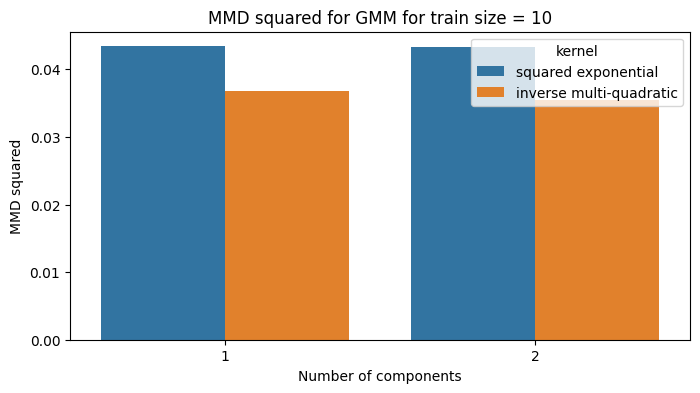

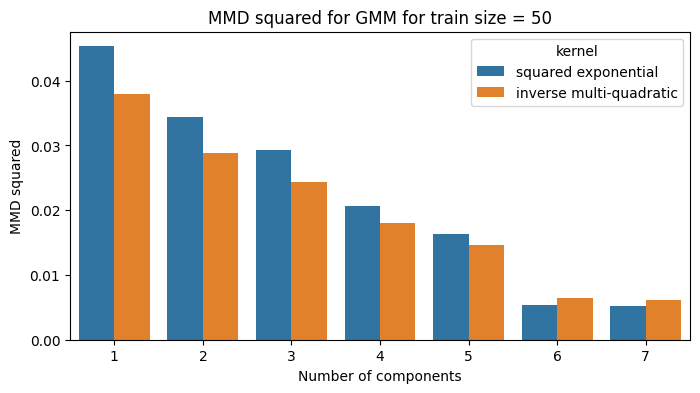

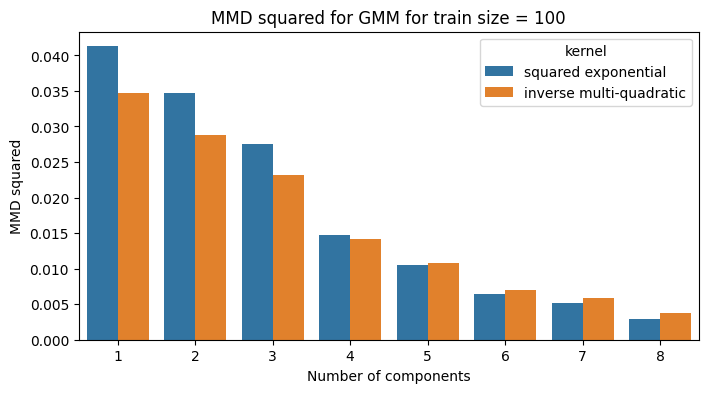

In [26]:
print('In case of an error, no bars are shown for the given number of components.')
plot_accuracy_gmm([1,2,3,4,5,6,7,8], train_sizes=train_sizes)

For GMM maximal values of MDD for each train set size are similar - about 0.04. Differences between kernels for the same case are small. For train size 10 there are only two generated results for each kernel and the results are similar. For train sizes 50 and 100, the differences are more significant. For both cases the trend is similar - the greater the number of components, the lower the value.

<div style="color: green; font-weight: bold">correct although the results are slightly different - for us, the lower the bandwidth, the lower the MMD which is caused by our nature of training set (no noise). </div>

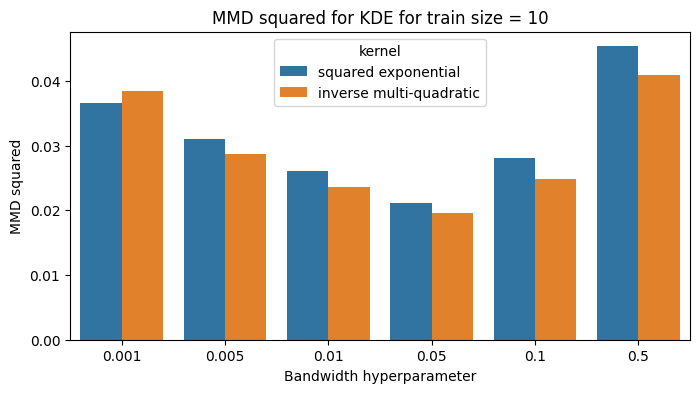

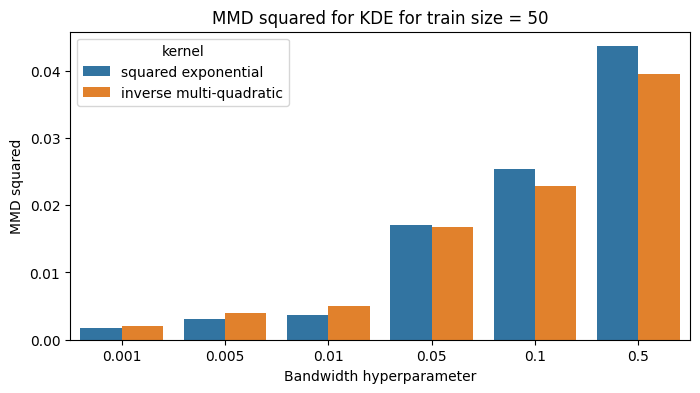

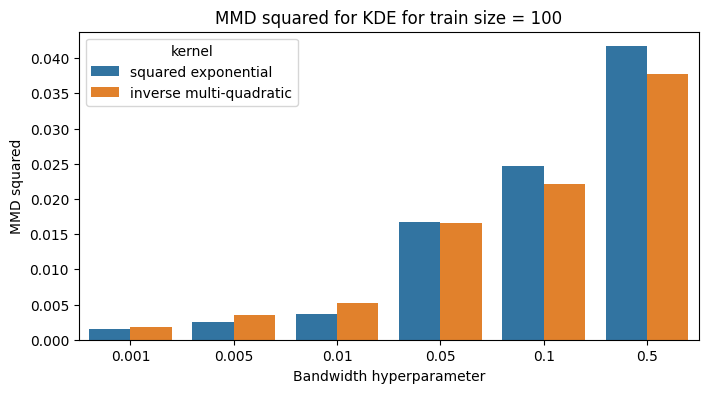

In [24]:
plot_accuracy_kde(kernel_bandwidths=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5], train_sizes=train_sizes)

Also for KDE maximal values of MDD for each train set size are similar - about 0.04. Differences between kernels for the same case are small. For train size 10 the results are similar for various bandwidths. For train sizes 50 and 100, the differences are more significant. For both cases the trends are similar - the greater the bandwidth, the higher the value.

### Comments

Results:
- too few training samples (10) cause either error (in the case of GMM with more than 2 components), or result in very different hyperparameter with the lowest MMD squared metric,
- 50 and 100 training samples are more adequate for this dataset as the results are similar to one another (for the given model).

In terms of hyperparameters when training on the dataset with enough (50 or 100) samples:
- for histogram, the best binwidth is around 0.01,
- for GMM, the best number of components is 6 or more (but probably not more than 10 as there would be insufficient data and the MMD might not continue to decrease beyond 8 components),
- for KDE, the best bandwidth seems to be the smallest one (0.001). 

Note, that our generated data has no noise therefore resulting hyperparameters try to approximate lines and not 'clouds' of points -> this might be the reason for, for example, the best bandwidth being the smallest one.

### Plots for learned densities

<div style="color: green; font-weight: bold">Densities from the models (corresponds to methods 'predict' from the correct solution):
- correct for histogram, their code looks more clean,
- correct for single gaussian model,
- correct for GMM,
- similar for KDE - their implementation did not use the squared exponential kernel (as stated in the task) but instead used a gaussian kernel.
- plots in the correct solution are missing labels for which model is given plot - our plots have more informative labels.</div>

In [27]:
def plot_density_two_d_histogram(model_parameters, figsize=(5,5)):
    """
    Function that plots density of two-dimensional histogram.

    Args:
        model_parameters (dict): dictionary with parameters of two-dimensional histogram.
        fig_size (tuple): size of the resulting plot.
    """
    count_matrix = model_parameters["count_matrix"]
    list_x_and_L = model_parameters["list_x_and_L"]
    X_max, X_min, y_max, y_min, L_x, L_y, bin_size=list_x_and_L
    x, y = np.mgrid[X_min:X_max:bin_size, y_min:y_max:bin_size]
    fig, ax = plt.subplots(figsize=figsize)
    ax.contourf(x, y, count_matrix.T)
    plt.axis('equal')
    ax.set_ylim(-1, 1.5)
    ax.set_xlim(-1.5, 2.5)
    plt.title('Density plot of two-dimensional histogram (smoothed)')
    plt.show()

def plot_density_single_gaussian(model_parameters, figsize=(5,5)):
    """
    Function that plots density of single gaussian distribution.

    Args:
        model_parameters (dict): dictionary with parameters of single gaussian distribution.
        fig_size (tuple): size of the resulting plot.
    """
    mean = model_parameters["mean"]
    cov = model_parameters["cov"]
    x, y = np.mgrid[-1.5:2.5:.01, -1:1.5:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = multivariate_normal(mean, cov)
    fig, ax = plt.subplots(figsize=figsize)
    ax.contourf(x, y, rv.pdf(pos))
    plt.axis('equal')
    plt.title('Density plot of single gaussian distribution')
    plt.show()

def plot_density_gmm(model_parameters, figsize=(5,5)):
    """
    Function that plots density of gaussian mixture model.

    Args:
        model_parameters (dict): dictionary with parameters of gaussian mixture model.
        fig_size (tuple): size of the resulting plot.
    """
    weights = model_parameters["weights"]
    means = model_parameters["means"]
    covariances = model_parameters["covariances"]
    x, y = np.mgrid[-1.5:2.5:.01, -1:1.5:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = np.zeros(x.shape)
    for i in range(len(weights)):
        rv += weights[i] * multivariate_normal(means[i], covariances[i]).pdf(pos)
    fig, ax = plt.subplots(figsize=figsize)
    ax.contourf(x, y, rv)
    plt.axis('equal')
    plt.title('Density plot of gaussian mixture model')
    plt.show()

def plot_density_kde(model_parameters, figsize=(5,5)):
    """
    Function that plots density of kernel density estimation.

    Args:
        model_parameters (dict): dictionary with train set and bandwidth.
        fig_size (tuple): size of the resulting plot.
    """
    train_set = model_parameters["train_set"]
    bandwidth = model_parameters["bandwidth"]
    x, y = np.mgrid[-1.5:2.5:.01, -1:1.5:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = np.zeros(x.shape)
    for i in range(len(train_set)):
        rv += squared_exponential_kernel(train_set[i], pos, bandwidth)
    rv /= (len(train_set) * bandwidth)
    fig, ax = plt.subplots(figsize=figsize)
    ax.contourf(x, y, rv)
    plt.axis('equal')
    plt.title('Density plot of kernel density estimation')
    plt.show()

#### Examples for good models

<div style="color: green; font-weight: bold">Differences:
- we made the plots separately while the solution created a more readable grid,
- we did not include comparison for different train set sizes which would be beneficial for the reader here,
- we did not scatterplot the original training set that the models tried to learn - also would be useful to add.
- due to the nature of our training set without noise, we did get much better appriximations of the original data.</div>

<div style="color: green; font-weight: bold">For histogram, the correct plot should have squares as the second but x and y scale as the first one (similarly to those from the correct solution). </div>

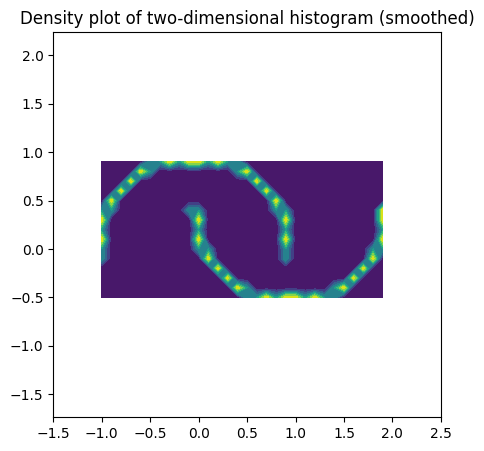

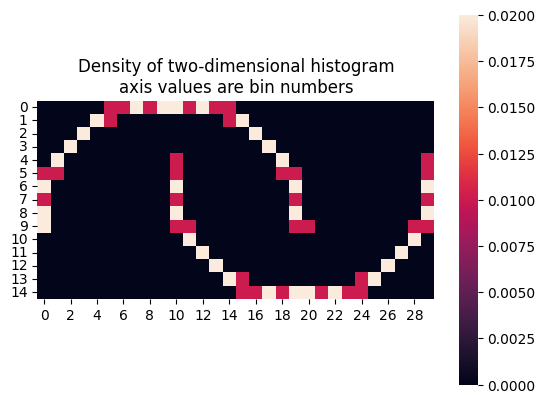

In [28]:
plot_density_two_d_histogram(model_parameters_two_d_histogram)
sns.heatmap(np.flip(model_parameters_two_d_histogram["count_matrix"]/np.sum(np.sum(model_parameters_two_d_histogram["count_matrix"])), axis=1), square=True)
plt.title('Density of two-dimensional histogram\naxis values are bin numbers')
plt.show()

For the above plots we can see, that the distribution of the data is to a certain degree similar to the distribution of original data - shapes look similar. The weakness of this method is that the moon shape on the distribution shape contains squares, and there are no smooth edges, which were present in the original data.

<div style="color: green; font-weight: bold">Correct</div>

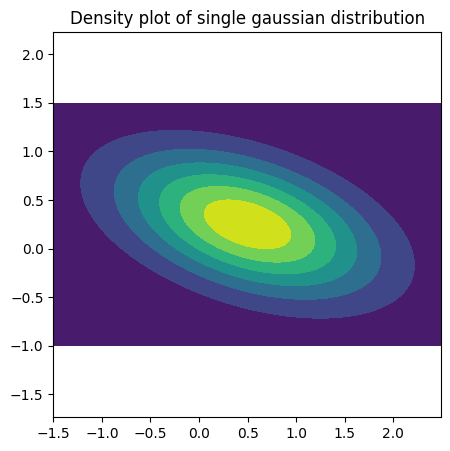

In [29]:
plot_density_single_gaussian(model_parameters_single_gaussian)

For the single Gaussian model the shape of the distribution has oval shape, which is not similar to the moon shape of the original data. That is the main weakness of the method.

<div style="color: green; font-weight: bold">Correct due to no noise added to our dataset</div>

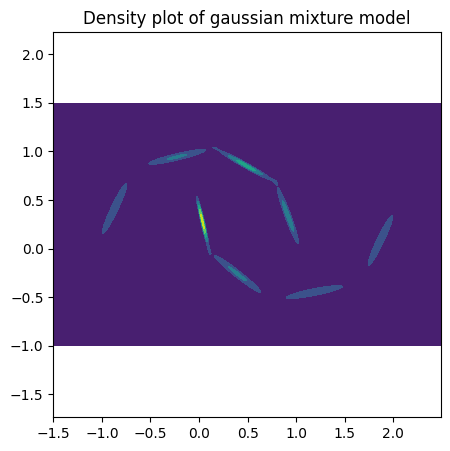

In [30]:
plot_density_gmm(model_parameters_gmm)

For GMM plot looks better than one for a single Gaussian, however, it is not as good as a histogram. The data here are also in some kind of moon shape, but the weakness is that there are holes between consecutive components, which was not present in the training dataset.

<div style="color: green; font-weight: bold">Correct due to very low bandwidth and no noise added to our dataset</div>

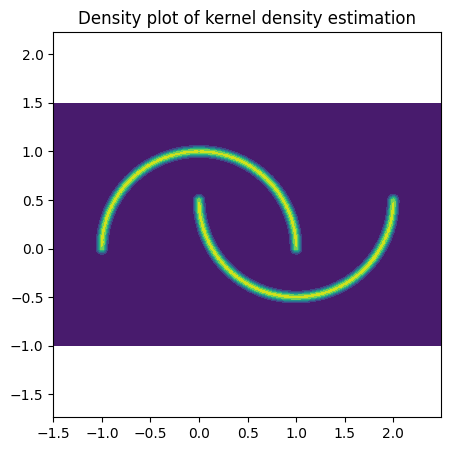

In [31]:
plot_density_kde(model_parameters_kde)

The density plot for KDE looks pretty much the same as the original dataset, which is a strength of this method.

##### Example of bad models

Below we introduce some examples of models that were not successful, mainly because of wrongly chosen hyperparameters.

The first example shows too big binsize for the histogram. The result is, that the distribution does not show the shape, which would be similar to the one of the training dataset.

<div style="color: green; font-weight: bold">Correct, not present in the sample solution. The only wrong here are values at axis ticks (should be x-y values of the bin centers instead of counting the bins)</div>

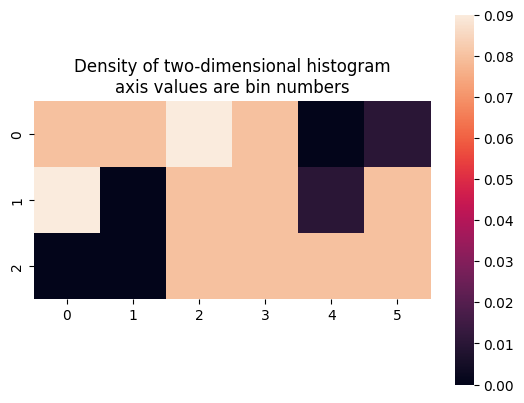

In [32]:
bad_model_parameters_two_d_histogram = two_d_histogram(train_set, bin_size=0.5)
sns.heatmap(np.flip(bad_model_parameters_two_d_histogram["count_matrix"]/np.sum(np.sum(bad_model_parameters_two_d_histogram["count_matrix"])), axis=1), square=True)
plt.title('Density of two-dimensional histogram\naxis values are bin numbers')
plt.show()

The second example shows too few components for GMM. The result is, that the density plot shows two oval shapes, similar to what happened for a single Gaussian. The number of components seems to play a crucial role in the shape of the resulting density plot.

<div style="color: green; font-weight: bold">Correct, not present in the sample solution.</div>

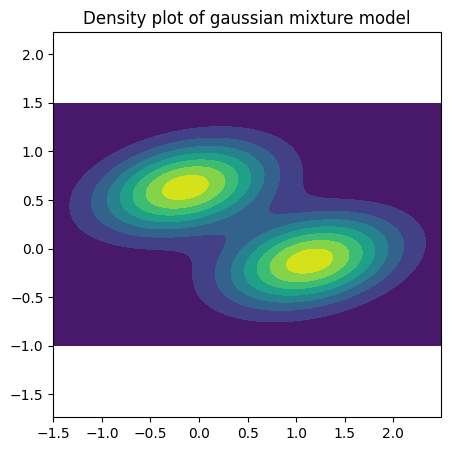

In [33]:
bad_model_parameters_gmm = train_gmm(train_set, components=2, n_iterations = 100)
plot_density_gmm(bad_model_parameters_gmm)

The third example shows too big bandwidth for KDE. The result is, that the moon's shape is really smooth, there are no clear boundaries and shapes, more like one big shape.

<div style="color: green; font-weight: bold">Correct, not present in the sample solution.</div>

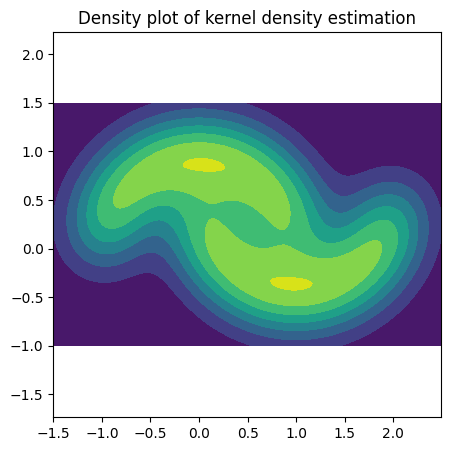

In [34]:
bad_model_parameters_kde = train_kde(train_set, bandwidth=0.1)
plot_density_kde(bad_model_parameters_kde)

### Plots showing generated data
For each of the models we below show plots with generated data.

<div style="color: green; font-weight: bold">Correct, differences:
- we present the generated data only for a set of models that were trained on the training set of one size whereas the solution presents them for 5 different training dataset sizes.
- we added titles about model name which are missing in the proposed solution
- plots in the correct solution are missing labels for which model is given plot - our plots have more informative labels.</div>

In [35]:
def plot_generated_data(points, figsize=(5,5), title='Generated data'):
    """
    Function that accepts 2d np array of coordinates of points and plots them

    Args:
        points (np.array): array of points.
        figsize (tuple): size of the output feature.
        title (str): title of the created plot.
    """
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(x=points[:,0], y=points[:,1], alpha=0.9, s=10, ax=ax)
    ax.axis('equal')
    ax.set_title(title)
    plt.show()

<div style="color: green; font-weight: bold">Correct, see the comment in the beginning of this section.</div>

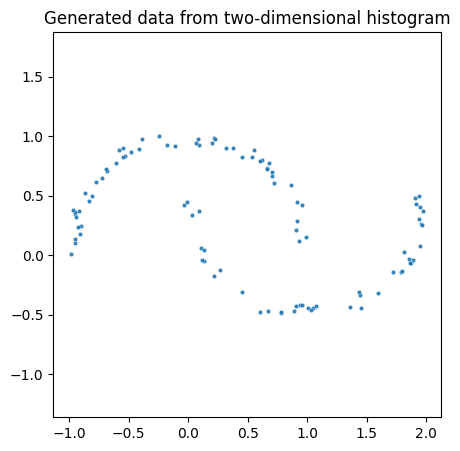

In [36]:
plot_generated_data(new_data_two_d_histogram, title='Generated data from two-dimensional histogram')

For histogram the data looks similar to those from training set.

<div style="color: green; font-weight: bold">Correct, see the comment in the beginning of this section.</div>

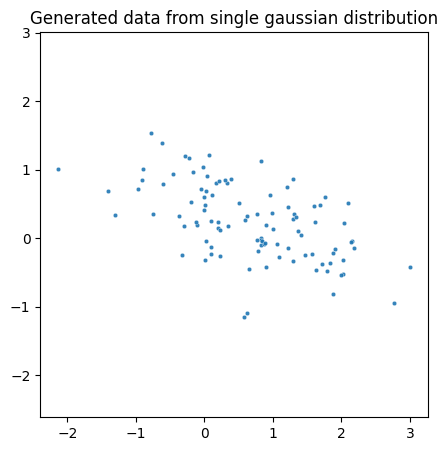

In [37]:
plot_generated_data(new_data_single_gaussian, title="Generated data from single gaussian distribution")

For singel Gaussian modethe data looks very different in comparison to those from training set.

<div style="color: green; font-weight: bold">Correct, see the comment in the beginning of this section.</div>

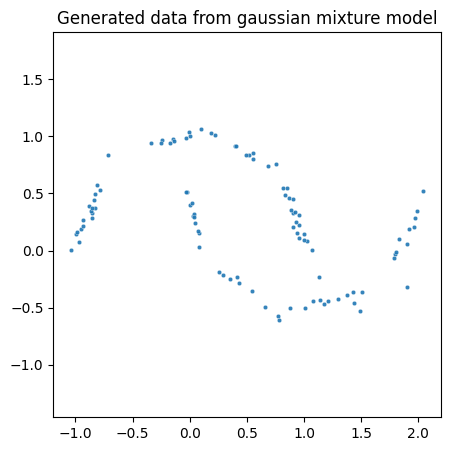

In [38]:
plot_generated_data(new_data_gmm, title="Generated data from gaussian mixture model")

For GMM the data looks similar to those from histogram and also kind of similar to the training set.

<div style="color: green; font-weight: bold">Correct, see the comment in the beginning of this section.</div>

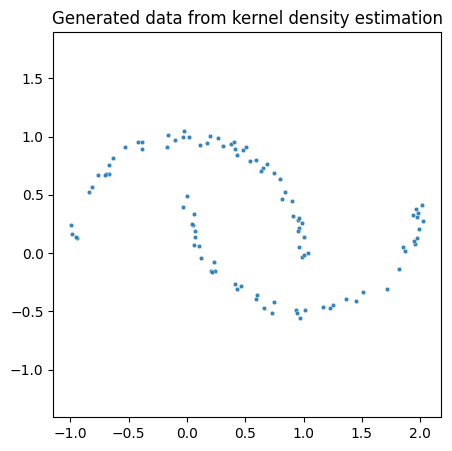

In [39]:
plot_generated_data(new_data_kde, title="Generated data from kernel density estimation")

For KDE the data looks similar to those from histogram and also kind of similar to the training set.

### Summary - Task 1

Based on the results of the conducted experiments we can say, that for the moon shape data problem, the best solution would be to use the KDE model. This model looks pretty similar to the training data, the best from the ones that were used in this exercise. The second best would be a histogram. The shape and similarity of GMM to the training data really depends on the number of components - for more components the shape is nearer to the original one. The single Gaussian method did not meet the expectations, the shape was not similar and there was no possibility to change it.

For experiments about hyperparameters, we can say that the bin size, number of components and bandwidth and train set size influence the resulting MMD value. However, it depends also on their mutual system of values, and how big the influence is.

## 2. Higher-dimensional data

Load data - digits from `sklearn.datasets.load_digits()` and later plot some examples to see how do they look like.

<div style="color: green; font-weight: bold">Correct</div>

In [40]:
digits = load_digits()
X = digits.data
y = digits.target
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

X shape: (1797, 64)
y shape: (1797,)


<div style="color: green; font-weight: bold">Correct, not present in the correct solution.</div>

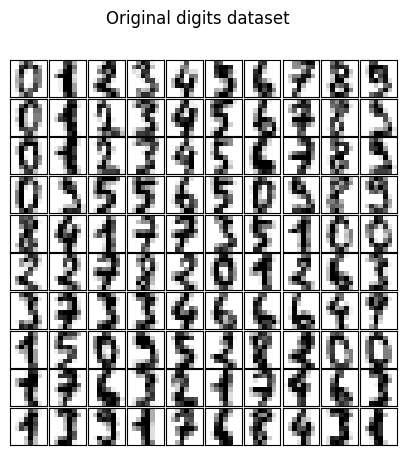

In [41]:
def plot_digits(data, title):
    data_processed = data.copy()
    data_processed[data_processed < 0] = 0
    data_processed[data_processed > 16] = 16

    fig, ax = plt.subplots(10, 10, figsize=(5,5),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data_processed[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
    plt.suptitle(title)
    plt.show()
plot_digits(digits.data, 'Original digits dataset')

### Train models with respect to MMD

<div style="color: green; font-weight: bold">Correct</div>

In [42]:
NUMBER_OF_GENERATED_DATA = 100

MMD function implementations

<div style="color: green; font-weight: bold">Same as the correct solution, we use both kernels for MMD with bandwidth 1.</div>

In [43]:
def metric_mmd_wrapper_squared_exponential(dataset):
    """
    Wrapper function that calculates squared MMD metric for given dataset.
    Sets bandwidth to 0.01 and uses squared exponential kernel.
    Uses test dataset.
    
    Args:
        dataset (np.array): array of points.
    """
    bandwidth = 1
    kernel_function = mmd_kernel_squared_exponential
    return metric_mmd_square(X_test, dataset, bandwidth, kernel_function)

def metric_mmd_wrapper_inverse_multiquadratic(dataset):
    """
    Wrapper function that calculates squared MMD metric for given dataset.
    Sets bandwidth to 0.01 and uses inverse multi-quadratic kernel.
    Uses test dataset.
    
    Args:
        dataset (np.array): array of points.
    """
    bandwidth = 1
    kernel_function = mmd_kernel_inverse_multiquadratic
    return metric_mmd_square(X_test, dataset, bandwidth, kernel_function)

Implementation of functions that are plotting digits with the use of various methods.

<div style="color: green; font-weight: bold">Differences:
- we did not include KDTrees,
- we used a single gaussian model which the proposed solution did not include for this task,
- we compare mmd of the same model for different values of it's hyperparameters which was not done in the correct solution.
</div>

In [44]:
def plot_gmm_digits_mmd(n_components, X_train):
    """
    Function which is ploting digits with the use of GMM from sklearn.mixture.

    Args:
        n_components (int): number of components used in GMM model.
        X_train (np.array): training dataset.
    """
    models = [GMM(n, covariance_type='full', random_state=0) for n in n_components]
    df = pd.DataFrame(columns=["components", "mmd_squared", "kernel"])
    for model in models:
        model.fit(X_train)
        new_data_gmm = model.sample(NUMBER_OF_GENERATED_DATA)[0]
        df = pd.concat([df, 
                        pd.DataFrame({
                            "components": [model.n_components, model.n_components],
                            "mmd_squared": [
                                metric_mmd_wrapper_squared_exponential(new_data_gmm),
                                metric_mmd_wrapper_inverse_multiquadratic(new_data_gmm)], 
                            "kernel": ["squared exponential", "inverse multi-quadratic"]
                        })])

    fig, ax = plt.subplots(figsize=(8,4))
    sns.barplot(x="components", y="mmd_squared", hue="kernel", data=df, ax=ax)
    plt.title("MMD squared for GMM")
    ax.set_ylabel("MMD squared")
    ax.set_xlabel("Number of components")
    margin_y = (df.mmd_squared.max() - df.mmd_squared.min()) * 0.1
    ax.set_ylim(df.mmd_squared.min()-margin_y, df.mmd_squared.max()+margin_y)
    plt.show()
    
def plot_kde_digits_mmd(bandwidths, X_train):
    """
    Function which is ploting digits with the use of KDE from sklearn.neighbors.

    Args:
        bandwidths (float): bandwidths to be used for KernelDensity model
        X_train (np.array): training dataset.
    """
    models = [KernelDensity(bandwidth=bandwidth, kernel='gaussian') for bandwidth in bandwidths] 
    df = pd.DataFrame(columns=["bandwidth", "mmd_squared", "kernel"])
    for model in models:
        model.fit(X_train)
        new_data_kde = model.sample(NUMBER_OF_GENERATED_DATA)
        df = pd.concat([df, 
                        pd.DataFrame({
                            "bandwidth": [model.bandwidth, model.bandwidth],
                            "mmd_squared": [
                                metric_mmd_wrapper_squared_exponential(new_data_kde),
                                metric_mmd_wrapper_inverse_multiquadratic(new_data_kde)], 
                            "kernel": ["squared exponential", "inverse multi-quadratic"]
                        })])

    fig, ax = plt.subplots(figsize=(8,4))
    sns.barplot(x="bandwidth", y="mmd_squared", hue="kernel", data=df, ax=ax)
    plt.title("MMD squared for KDE")
    ax.set_ylabel("MMD squared")
    ax.set_xlabel("Bandwidth hyperparameter")
    margin_y = (df.mmd_squared.max() - df.mmd_squared.min()) * 0.1
    ax.set_ylim(df.mmd_squared.min()-margin_y, df.mmd_squared.max()+margin_y)
    plt.show()

## Train models

Single Gaussian and MMD results for it. Also here the results for different kernels are similar.

<div style="color: green; font-weight: bold">Correct</div>

In [45]:
mean = np.mean(X_train, axis=0)
cov = np.cov(X_train.T)
model_parameters_single_gaussian = {"mean":mean, "cov":cov}

<div style="color: green; font-weight: bold">The obtained MMD metric values are very different from those obtained in the correct solution.</div>

In [46]:
new_data_single_gaussian = generate_data_single_gaussian(model_parameters_single_gaussian, number_of_generated=NUMBER_OF_GENERATED_DATA)
print(f'MMD squared with squared exponential kernel for single gaussian: {metric_mmd_wrapper_squared_exponential(new_data_single_gaussian):.6f}')
print(f'MMD squared with inverse multi-quadratic kernel for single gaussian: {metric_mmd_wrapper_inverse_multiquadratic(new_data_single_gaussian):.6f}')

MMD squared with squared exponential kernel for single gaussian: 0.011956
MMD squared with inverse multi-quadratic kernel for single gaussian: 0.011976


GMM

<div style="color: green; font-weight: bold">Correct, plot not present in the correct solution</div>

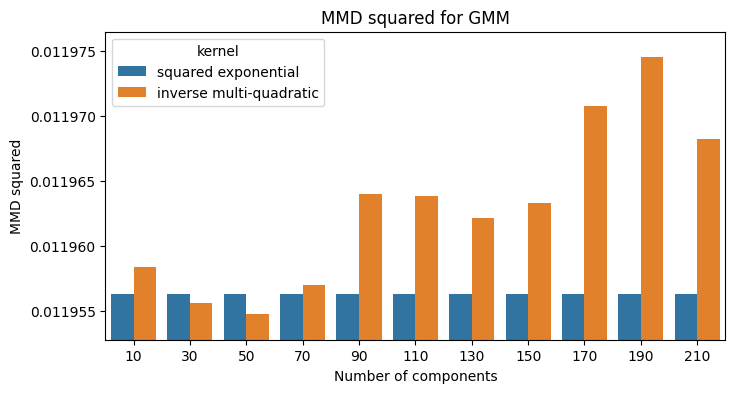

In [47]:
n_components = np.arange(10, 230, 20)
plot_gmm_digits_mmd(n_components, X_train)

For GMM for various numbers of components and various kernels, the MMD value is similar - nearly 0.12.

<div style="color: green; font-weight: bold">Correct, they used 64 components (same as the number of pixels) and we used 50 according to our plot from earlier.</div>

In [59]:
model_digits_gmm = GMM(n_components=50, covariance_type='full', random_state=0)
model_digits_gmm.fit(X_train);

<div style="color: green; font-weight: bold">The obtained MMD metric values are very different from those obtained in the correct solution.</div>

In [60]:
new_data_gmm = model_digits_gmm.sample(NUMBER_OF_GENERATED_DATA)[0]
print(f'MMD squared with squared exponential kernel for GMM: {metric_mmd_wrapper_squared_exponential(new_data_gmm):.6f}')
print(f'MMD squared with inverse multi-quadratic kernel for GMM: {metric_mmd_wrapper_inverse_multiquadratic(new_data_gmm):.6f}')

MMD squared with squared exponential kernel for GMM: 0.011956
MMD squared with inverse multi-quadratic kernel for GMM: 0.011955


KDE

Note: using gaussian kernel as it provides built-in sampling (on the contrary to inverse exponential kernel used in the previous task).

<div style="color: green; font-weight: bold">Correct, plot not present in the correct solution.</div>

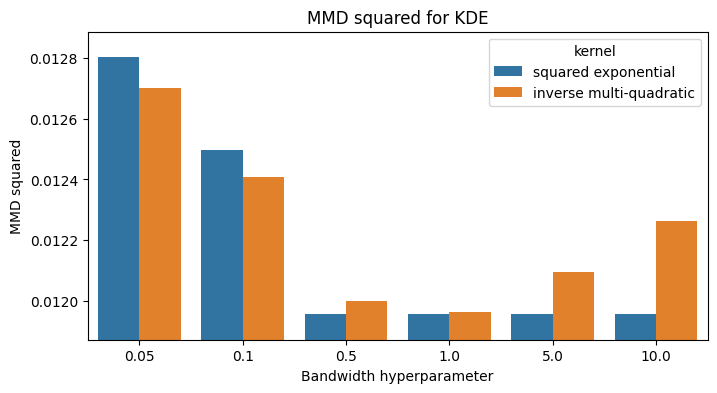

In [50]:
bandwidths = np.array([0.05, 0.1, 0.5, 1, 5, 10])
plot_kde_digits_mmd(bandwidths, X_train)

The differences in MMD for various kernels for various bandwidth values are small, the results vary from 0.120 to 0.128.

<div style="color: green; font-weight: bold">The obtained MMD metric values are very different from those obtained in the correct solution. </div>

In [51]:
new_data_kde = KernelDensity(bandwidth=1).fit(X_train).sample(NUMBER_OF_GENERATED_DATA)
print(f'MMD squared with squared exponential kernel for KDE: {metric_mmd_wrapper_squared_exponential(new_data_kde):.6f}')
print(f'MMD squared with inverse multi-quadratic kernel for KDE: {metric_mmd_wrapper_inverse_multiquadratic(new_data_kde):.6f}')

MMD squared with squared exponential kernel for KDE: 0.011956
MMD squared with inverse multi-quadratic kernel for KDE: 0.011960


##### MMD summary
For all of the examples, values are pretty similar.

<div style="color: green; font-weight: bold">The obtained MMD metric values are very different from those obtained in the correct solution. There should be an explanation for that in the implementation of the MMD metric and we did spot a few differences indeed although they should not matter this much.</div>

In [61]:
print('MMD squared with squared exponential kernel:')
print(f'for single gaussian: {metric_mmd_wrapper_squared_exponential(new_data_single_gaussian):.10f}')
print(f'for GMM: {metric_mmd_wrapper_squared_exponential(new_data_gmm):.10f}')
print(f'for KDE: {metric_mmd_wrapper_squared_exponential(new_data_kde):.10f}')

MMD squared with squared exponential kernel:
for single gaussian: 0.0119562977
for GMM: 0.0119562977
for KDE: 0.0119562977


In [62]:
print('MMD squared with inverse multi-quadratic kernel:')
print(f'for single gaussian: {metric_mmd_wrapper_inverse_multiquadratic(new_data_single_gaussian):.8f}')
print(f'for GMM: {metric_mmd_wrapper_inverse_multiquadratic(new_data_gmm):.8f}')
print(f'for KDE: {metric_mmd_wrapper_inverse_multiquadratic(new_data_kde):.8f}')

MMD squared with inverse multi-quadratic kernel:
for single gaussian: 0.01197591
for GMM: 0.01195479
for KDE: 0.01195978


##### Samples generated by models

Even though the values of MMD were similar between the methods, when the digits are plotted, some of them look better, the digits are easily visible like in GMM and KDE, and sometimes worse, like for single Gaussian distribution.

<div style="color: green; font-weight: bold">The obtained results are similar. The difference is that they included KDTree and we included single gaussian.</div>

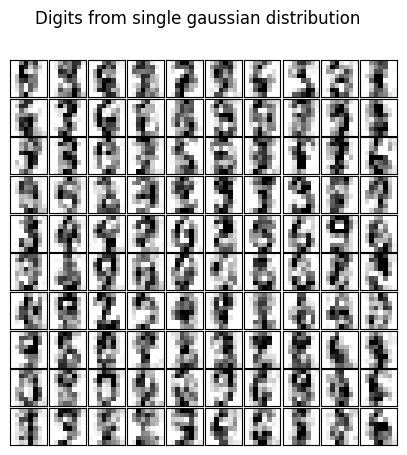

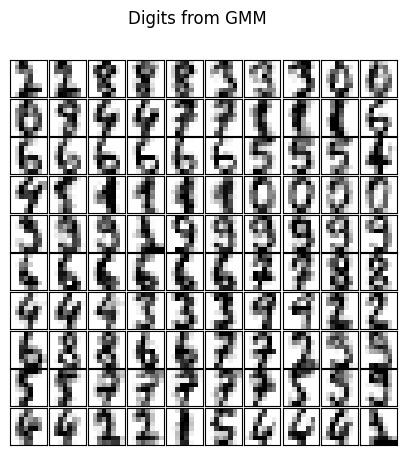

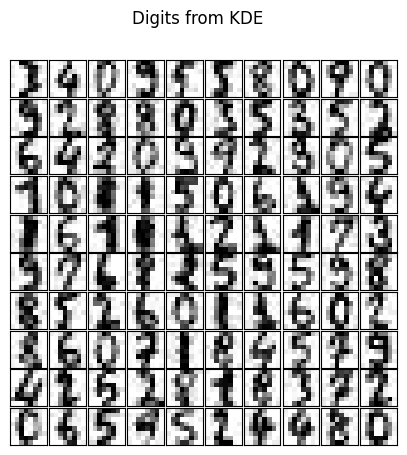

In [63]:
plot_digits(new_data_single_gaussian, 'Digits from single gaussian distribution')
plot_digits(new_data_gmm, 'Digits from GMM')
plot_digits(new_data_kde, 'Digits from KDE')

Original data - which looks readible.

<div style="color: green; font-weight: bold">Correct</div>

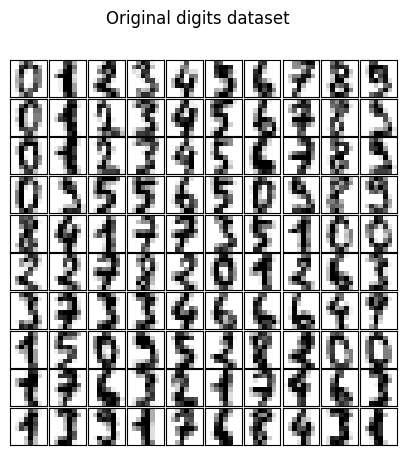

In [55]:
plot_digits(digits.data, 'Original digits dataset')

#### Classifying generated data

The aim here is to train Random Forest Classifier on original data and check the accuracy on test data. The accuracy is about 0.97, so very high. Later the model was used to predict classes of the generated data from different models - single Gaussian, GMM and KDE. The aim was to see if the digits generated by models were in equal proportions.

<div style="color: green; font-weight: bold">Correct</div>

In [56]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f'Accuracy on original test data: {accuracy_score(y_test, y_pred):.4f}')

Accuracy on original test data: 0.9667


Now plot count of predicted classes on generated data from different models

<div style="color: green; font-weight: bold">Correct</div>

In [80]:
from matplotlib import ticker as mtick

def plot_predictions(data, title):
    y_pred = rf.predict(data)
    counted = dict(Counter(y_pred))
    keys = np.arange(10)
    values = np.zeros(10)
    for key, value in counted.items():
        values[key] = value / len(y_pred)
    df = pd.DataFrame({'Digit': keys, 'Percentage of predictions': values})
    df = df.sort_values(by='Digit')
    fig, ax = plt.subplots(figsize=(4,3))
    sns.barplot(x='Digit', y='Percentage of predictions', data=df, ax=ax)
    plt.title(title)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
    plt.show()

<div style="color: green; font-weight: bold">Correct, different results than those obtained in the original solution. Overall, obtained predictions distributions have more variance than those from the correct solution. This might be caused by the low sample size that we generated here.</div>

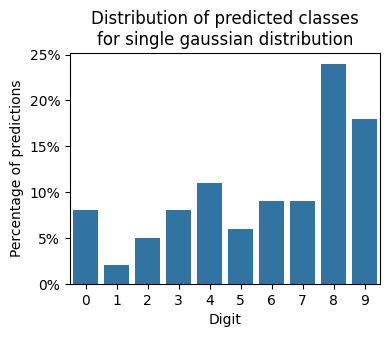

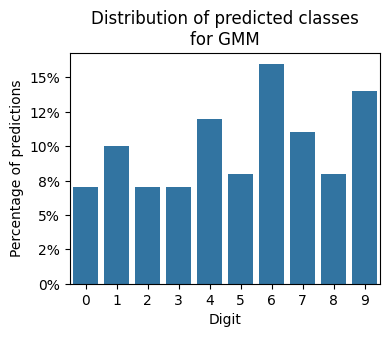

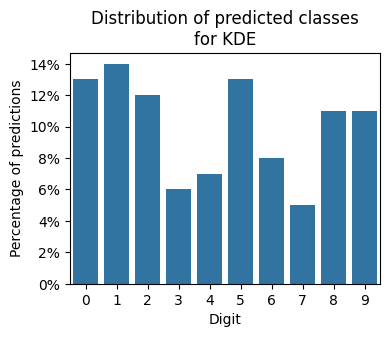

In [81]:
plot_predictions(new_data_single_gaussian, 'Distribution of predicted classes\nfor single gaussian distribution')
plot_predictions(new_data_gmm, 'Distribution of predicted classes\nfor GMM')
plot_predictions(new_data_kde, 'Distribution of predicted classes\nfor KDE')

### Summary - Task 2

Generating a complex, high-dimensional distribution of data also requires a model more complex than a single Gaussian distribution. This is clearly visible in the newly generated data - KDE and GMM both generate plausible data whereas the single Gaussian model generates images that humans cannot recognize as digits.

This is somewhat confirmed by the distribution of classes that the classifier (trained on original data and achieving 97% accuracy on test data) predicts for the generated data. In data from the single Gaussian model, our classifier mostly sees number 8 - which covers the most of the image which might be the reason. Among data generated by GME and KDE, distribution is more uniform and closer to the original data.

## Summary - whole assignment

After finishing this assignment, these are the conclusions:
- KDE and GMM proved to be the best,
- Single Gaussian model is not good for generating data - for datasets used in the experiments it was not able to generate data similar to the original datasets as it is far too simple. It has no hyperparameters too.
A histogram is good as long as the number of dimensions is not too big. For higher dimensions, it is not possible to use it, as it is not possible to create a histogram for such data (curse of dimensionality - we would need a lot of data to fill all the bins).

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=22b4dfed-b0b9-470e-8974-d4984b0358ad' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>